In [82]:
import pandas as pd
import numpy as np
import datetime as dt
import julian
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## Load in data

In [83]:
# Select only pertinent features (this should make loading in data faster)
con = sqlite3.connect("wildfire_data.sqlite")

query="""
SELECT 
FIRE_NAME,
FIRE_SIZE_CLASS,
STAT_CAUSE_DESCR, STAT_CAUSE_CODE,
STATE, COUNTY,
LONGITUDE, LATITUDE,
DISCOVERY_DATE, 
DISCOVERY_TIME, 
CONT_DATE, 
CONT_TIME,
FIRE_YEAR
from Fires
"""
query=query.strip()
df = pd.read_sql_query(query, con)
con.close();

In [84]:
print(df.shape)
df.head()

(1880465, 13)


,FIRE_NAME,FIRE_SIZE_CLASS,STAT_CAUSE_DESCR,STAT_CAUSE_CODE,STATE,COUNTY,LONGITUDE,LATITUDE,DISCOVERY_DATE,DISCOVERY_TIME,CONT_DATE,CONT_TIME,FIRE_YEAR
0,FOUNTAIN,A,Miscellaneous,9.0,CA,63,-121.005833,40.036944,2453403.5,1300,2453403.5,1730,2005
1,PIGEON,A,Lightning,1.0,CA,61,-120.404444,38.933056,2453137.5,0845,2453137.5,1530,2004
2,SLACK,A,Debris Burning,5.0,CA,17,-120.735556,38.984167,2453156.5,1921,2453156.5,2024,2004
3,DEER,A,Lightning,1.0,CA,3,-119.913333,38.559167,2453184.5,1600,2453189.5,1400,2004
4,STEVENOT,A,Lightning,1.0,CA,3,-119.933056,38.559167,2453184.5,1600,2453189.5,1200,2004


## Drop rows with missing data
Given our data is not sparse at all, we have the freedom to just drop all rows that are missing data we care about.

In [85]:
# drop the following rows if they have missing data for the following features
needed_cols = ['FIRE_SIZE_CLASS', 'DISCOVERY_DATE', 'DISCOVERY_TIME', 'CONT_DATE', 'CONT_TIME', 'STAT_CAUSE_CODE', 'STATE', 'LONGITUDE', 'LATITUDE']
df = df.dropna(subset=needed_cols) # remove rows where both of these are missing
df.shape

(892007, 13)

## Create new columns to work with

Map fire size class to integers so they can be ordered.

In [86]:
di = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7}
df['FIRE_SIZE_CLASS'] = df['FIRE_SIZE_CLASS'].map(di)

Map states to indices to help handle categorical

In [87]:
states = df.STATE.unique()
ind = states.argsort(axis=0)
state_di = {states[i]: i for i in ind}
df['STATE_CODE']=df['STATE'].map(state_di)

Convert the date/time columns to datetime objects. Originally they are in julian time. Also calculate the time to containment (time delta of containment date - discovery date)

In [88]:
#To make these dates and times easier to manage, let's convert them to datetime. We can add new columns DISCOVERY_DATETIME and CONTAINMENT_DATETIME.
df['DISCOVERY_DATETIME'] = df['DISCOVERY_DATE'];
df['CONT_DATETIME'] = df['CONT_DATE'];

In [89]:
#To populate those two rows, let's convert them into datetime.
df['DISCOVERY_DATETIME'] = df['DISCOVERY_DATETIME'].apply(lambda x: julian.from_jd(x, fmt="jd"))
df['CONT_DATETIME'] = df['CONT_DATETIME'].apply(lambda x:julian.from_jd(x, fmt="jd"))

In [90]:
#Let's also add the time 
temp_df = pd.DataFrame();
temp_df['dt'] = df['DISCOVERY_TIME'].apply(lambda x: dt.timedelta(hours=int(x[0:2]), minutes=int(x[2:5])))
df['DISCOVERY_DATETIME'] = df['DISCOVERY_DATETIME'] + temp_df['dt']
df['DISCOVERY_DATETIME'].head()

0   2005-02-02 13:00:00
1   2004-05-12 08:45:00
2   2004-05-31 19:21:00
3   2004-06-28 16:00:00
4   2004-06-28 16:00:00
Name: DISCOVERY_DATETIME, dtype: datetime64[ns]

In [91]:
#Do the same thing for CONT_DATETIME
temp_df = pd.DataFrame();
temp_df['dt'] = df['CONT_TIME'].apply(lambda x: dt.timedelta(hours=int(x[0:2]), minutes=int(x[2:5])))
df['CONT_DATETIME'] = df['CONT_DATETIME'] + temp_df['dt']
df['CONT_DATETIME'].head()

0   2005-02-02 17:30:00
1   2004-05-12 15:30:00
2   2004-05-31 20:24:00
3   2004-07-03 14:00:00
4   2004-07-03 12:00:00
Name: CONT_DATETIME, dtype: datetime64[ns]

In [92]:
df.to_csv("data_with_target.csv")
#Checkpoint to save the data with the above columns before reloading

In [93]:
df = pd.read_csv("data_with_target.csv")

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (1,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [94]:
dict(zip(df.STAT_CAUSE_CODE,df.STAT_CAUSE_DESCR))

{9.0: 'Miscellaneous',
 1.0: 'Lightning',
 5.0: 'Debris Burning',
 4.0: 'Campfire',
 2.0: 'Equipment Use',
 7.0: 'Arson',
 8.0: 'Children',
 6.0: 'Railroad',
 3.0: 'Smoking',
 11.0: 'Powerline',
 12.0: 'Structure',
 10.0: 'Fireworks',
 13.0: 'Missing/Undefined'}

In [95]:
df['CONT_DATETIME'] = df['CONT_DATETIME'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df['DISCOVERY_DATETIME'] = df['DISCOVERY_DATETIME'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df['TIME_TO_CONT'] = df['CONT_DATETIME'] - df['DISCOVERY_DATETIME']

df['TIME_TO_CONT'].describe()

count                        892007
mean      1 days 06:44:52.524004856
std      13 days 19:33:02.720135648
min                 0 days 00:00:00
25%                 0 days 00:30:00
50%                 0 days 01:28:00
75%                 0 days 04:45:00
max              3653 days 01:30:00
Name: TIME_TO_CONT, dtype: object

In [96]:
# convert to hours for easier sorting
df['HOURS_TO_CONT'] = df['TIME_TO_CONT'].apply(lambda x: round(float(x.total_seconds()/60/60)),2)
df.HOURS_TO_CONT.describe()

count    892007.000000
mean         30.728347
std         331.551520
min           0.000000
25%           0.000000
50%           1.000000
75%           5.000000
max       87674.000000
Name: HOURS_TO_CONT, dtype: float64

## Regression Analysis

In [97]:
# drop columns not used in feature analysis
drop_cols = ['FIRE_NAME', 'STAT_CAUSE_DESCR', 'STATE', 'COUNTY', 'DISCOVERY_DATE', 'DISCOVERY_DATETIME',
             'CONT_DATE', 'CONT_DATETIME', 'TIME_TO_CONT', 'Unnamed: 0']
data_for_features = df.drop(drop_cols, axis=1)
data_for_features = data_for_features[data_for_features.HOURS_TO_CONT < 3000]
data_for_features.head()

,FIRE_SIZE_CLASS,STAT_CAUSE_CODE,LONGITUDE,LATITUDE,DISCOVERY_TIME,CONT_TIME,FIRE_YEAR,STATE_CODE,HOURS_TO_CONT
0,1,9.0,-121.005833,40.036944,1300,1730,2005,0,4
1,1,1.0,-120.404444,38.933056,845,1530,2004,0,7
2,1,5.0,-120.735556,38.984167,1921,2024,2004,0,1
3,1,1.0,-119.913333,38.559167,1600,1400,2004,0,118
4,1,1.0,-119.933056,38.559167,1600,1200,2004,0,116


In [98]:
# declare inputs and target variables
target = data_for_features['HOURS_TO_CONT']
inputs = data_for_features.drop(['HOURS_TO_CONT'], axis=1)

### Using all of the features to fit the linear regression model for the target

In [99]:
errors = []
scores = []

for i in range(10):
    # train and test split
    X_train, X_test, y_train, y_test = train_test_split(inputs, target, shuffle=True, test_size=0.2)

    # create a linear regression object
    reg = LinearRegression()
    
    # fit the regression with the scaled train inputs and target
    reg.fit(X_train, y_train)
    
    # store outputs of regression in y_hat
    y_hat = reg.predict(X_train)
    
    print("Iteration: ", i + 1)
    # show the coefficients
    print("Coefficients: ", reg.coef_)
    # show the mean squared error
    mse = np.mean((reg.predict(X_test) - y_test) ** 2)
    print("Mean squared error: %.2f" % mse)
    # show the explained variance score (1 is perfect)
    score = reg.score(X_test, y_test)
    print("Variance score: %.2f" % score)    
    scores.append(score)
    errors.append(mse)
    print()
    
print("Overall:")
print("----------------------------------")
print("MSE {:0.2f}".format(sum(errors) / 10))
print("Variance {:0.2f}".format(sum(scores) / 10))

Iteration:  1
Coefficients:  [ 4.00502013e+01 -4.32513858e+00 -1.33288412e+00  2.86631628e+00
  1.65948848e-02 -2.71072841e-02  1.47136896e+00  7.59321478e-01]
Mean squared error: 19307.65
Variance score: 0.10

Iteration:  2
Coefficients:  [ 3.97526218e+01 -4.30686510e+00 -1.34597603e+00  2.85232042e+00
  1.65121598e-02 -2.67420480e-02  1.49297249e+00  7.79489510e-01]
Mean squared error: 19798.00
Variance score: 0.10

Iteration:  3
Coefficients:  [ 4.01831876e+01 -4.35888324e+00 -1.33613897e+00  2.87986523e+00
  1.72219471e-02 -2.79484427e-02  1.46020317e+00  7.57889716e-01]
Mean squared error: 18873.37
Variance score: 0.10

Iteration:  4
Coefficients:  [ 3.96468823e+01 -4.28822734e+00 -1.31975487e+00  2.86932468e+00
  1.64586972e-02 -2.68095629e-02  1.45013214e+00  7.50061946e-01]
Mean squared error: 19910.16
Variance score: 0.10

Iteration:  5
Coefficients:  [ 4.01041642e+01 -4.31311130e+00 -1.34506445e+00  2.88227694e+00
  1.71262112e-02 -2.72349834e-02  1.47979696e+00  7.73986224e-

### Using each feature alone to fit a linear regression model on the training set

----------------------------------
Iteration:  1
Analyzing column: FIRE_SIZE_CLASS
Coefficients:  [35.12451489]
Mean squared error: 21743.68
Variance score: 0.04


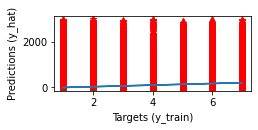

----------------------------------
Iteration:  1
Analyzing column: STAT_CAUSE_CODE
Coefficients:  [-4.81532578]
Mean squared error: 22450.05
Variance score: 0.01


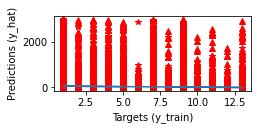

----------------------------------
Iteration:  1
Analyzing column: LONGITUDE
Coefficients:  [-1.1907132]
Mean squared error: 22359.63
Variance score: 0.02


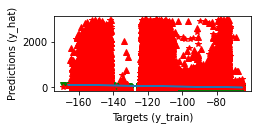

----------------------------------
Iteration:  1
Analyzing column: LATITUDE
Coefficients:  [3.68638848]
Mean squared error: 22252.26
Variance score: 0.02


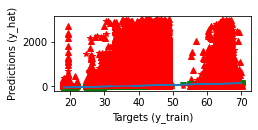

----------------------------------
Iteration:  1
Analyzing column: DISCOVERY_TIME
Coefficients:  [0.00054889]
Mean squared error: 22724.20
Variance score: -0.00


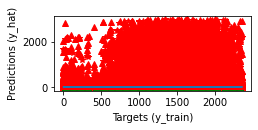

----------------------------------
Iteration:  1
Analyzing column: CONT_TIME
Coefficients:  [-0.01498376]
Mean squared error: 22681.53
Variance score: 0.00


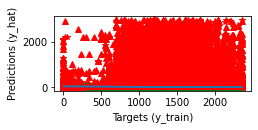

----------------------------------
Iteration:  1
Analyzing column: FIRE_YEAR
Coefficients:  [1.01886056]
Mean squared error: 22669.02
Variance score: 0.00


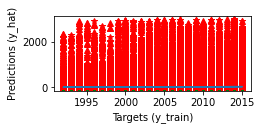

----------------------------------
Iteration:  1
Analyzing column: STATE_CODE
Coefficients:  [-0.52417428]
Mean squared error: 22675.10
Variance score: 0.00


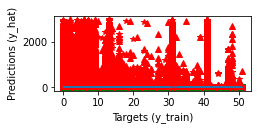

----------------------------------
Iteration:  2
Analyzing column: FIRE_SIZE_CLASS
Coefficients:  [34.697029]
Mean squared error: 20839.53
Variance score: 0.05


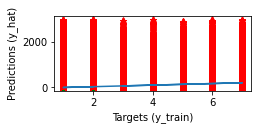

----------------------------------
Iteration:  2
Analyzing column: STAT_CAUSE_CODE
Coefficients:  [-4.82322037]
Mean squared error: 21642.89
Variance score: 0.01


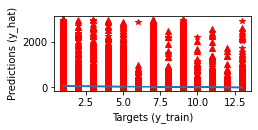

----------------------------------
Iteration:  2
Analyzing column: LONGITUDE
Coefficients:  [-1.175912]
Mean squared error: 21513.85
Variance score: 0.02


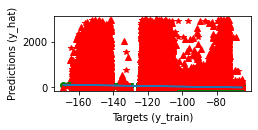

----------------------------------
Iteration:  2
Analyzing column: LATITUDE
Coefficients:  [3.69289314]
Mean squared error: 21451.14
Variance score: 0.02


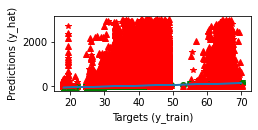

----------------------------------
Iteration:  2
Analyzing column: DISCOVERY_TIME
Coefficients:  [0.00047702]
Mean squared error: 21916.34
Variance score: 0.00


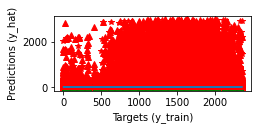

----------------------------------
Iteration:  2
Analyzing column: CONT_TIME
Coefficients:  [-0.01471104]
Mean squared error: 21867.68
Variance score: 0.00


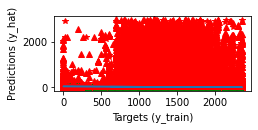

----------------------------------
Iteration:  2
Analyzing column: FIRE_YEAR
Coefficients:  [1.04843878]
Mean squared error: 21874.22
Variance score: 0.00


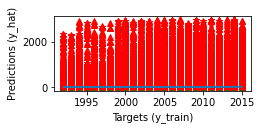

----------------------------------
Iteration:  2
Analyzing column: STATE_CODE
Coefficients:  [-0.51563661]
Mean squared error: 21860.37
Variance score: 0.00


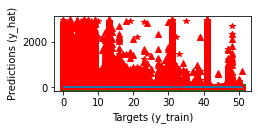

----------------------------------
Iteration:  3
Analyzing column: FIRE_SIZE_CLASS
Coefficients:  [35.01599187]
Mean squared error: 21372.16
Variance score: 0.04


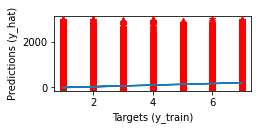

----------------------------------
Iteration:  3
Analyzing column: STAT_CAUSE_CODE
Coefficients:  [-4.84541304]
Mean squared error: 22098.69
Variance score: 0.01


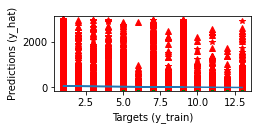

----------------------------------
Iteration:  3
Analyzing column: LONGITUDE
Coefficients:  [-1.19434449]
Mean squared error: 22006.80
Variance score: 0.02


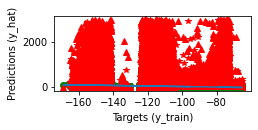

----------------------------------
Iteration:  3
Analyzing column: LATITUDE
Coefficients:  [3.73541794]
Mean squared error: 21937.69
Variance score: 0.02


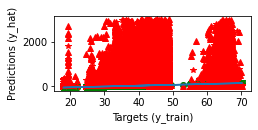

----------------------------------
Iteration:  3
Analyzing column: DISCOVERY_TIME
Coefficients:  [0.00066066]
Mean squared error: 22361.60
Variance score: -0.00


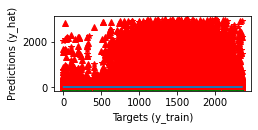

----------------------------------
Iteration:  3
Analyzing column: CONT_TIME
Coefficients:  [-0.01495881]
Mean squared error: 22318.09
Variance score: 0.00


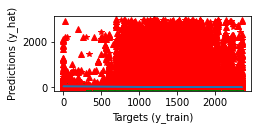

----------------------------------
Iteration:  3
Analyzing column: FIRE_YEAR
Coefficients:  [1.0178033]
Mean squared error: 22305.81
Variance score: 0.00


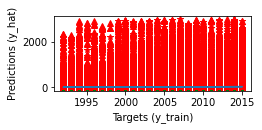

----------------------------------
Iteration:  3
Analyzing column: STATE_CODE
Coefficients:  [-0.51582465]
Mean squared error: 22305.86
Variance score: 0.00


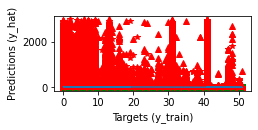

----------------------------------
Iteration:  4
Analyzing column: FIRE_SIZE_CLASS
Coefficients:  [34.67049835]
Mean squared error: 20982.72
Variance score: 0.05


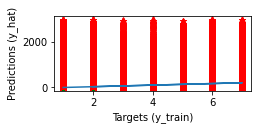

----------------------------------
Iteration:  4
Analyzing column: STAT_CAUSE_CODE
Coefficients:  [-4.80121606]
Mean squared error: 21785.23
Variance score: 0.01


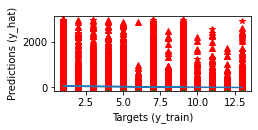

----------------------------------
Iteration:  4
Analyzing column: LONGITUDE
Coefficients:  [-1.17874231]
Mean squared error: 21672.54
Variance score: 0.02


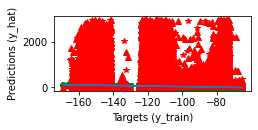

----------------------------------
Iteration:  4
Analyzing column: LATITUDE
Coefficients:  [3.69914774]
Mean squared error: 21608.56
Variance score: 0.02


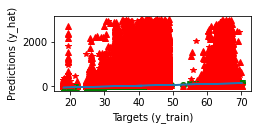

----------------------------------
Iteration:  4
Analyzing column: DISCOVERY_TIME
Coefficients:  [0.00054904]
Mean squared error: 22067.81
Variance score: -0.00


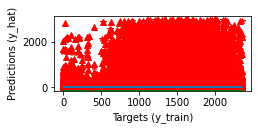

----------------------------------
Iteration:  4
Analyzing column: CONT_TIME
Coefficients:  [-0.0149758]
Mean squared error: 22024.85
Variance score: 0.00


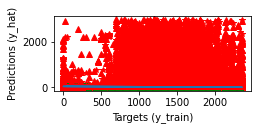

----------------------------------
Iteration:  4
Analyzing column: FIRE_YEAR
Coefficients:  [1.01473463]
Mean squared error: 22010.94
Variance score: 0.00


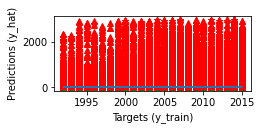

----------------------------------
Iteration:  4
Analyzing column: STATE_CODE
Coefficients:  [-0.51920795]
Mean squared error: 22014.74
Variance score: 0.00


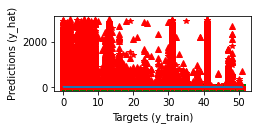

----------------------------------
Iteration:  5
Analyzing column: FIRE_SIZE_CLASS
Coefficients:  [35.29426649]
Mean squared error: 19899.37
Variance score: 0.05


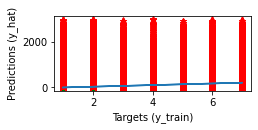

----------------------------------
Iteration:  5
Analyzing column: STAT_CAUSE_CODE
Coefficients:  [-4.89315371]
Mean squared error: 20605.15
Variance score: 0.01


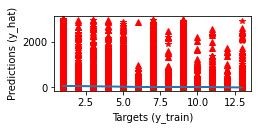

----------------------------------
Iteration:  5
Analyzing column: LONGITUDE
Coefficients:  [-1.19357432]
Mean squared error: 20489.74
Variance score: 0.02


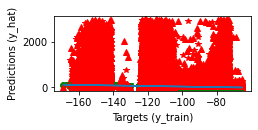

----------------------------------
Iteration:  5
Analyzing column: LATITUDE
Coefficients:  [3.69147704]
Mean squared error: 20376.24
Variance score: 0.02


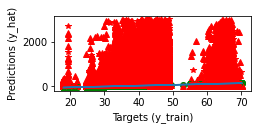

----------------------------------
Iteration:  5
Analyzing column: DISCOVERY_TIME
Coefficients:  [0.00057541]
Mean squared error: 20847.72
Variance score: -0.00


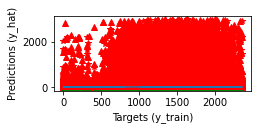

----------------------------------
Iteration:  5
Analyzing column: CONT_TIME
Coefficients:  [-0.01514721]
Mean squared error: 20808.81
Variance score: 0.00


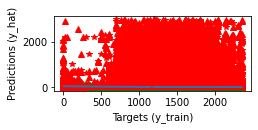

----------------------------------
Iteration:  5
Analyzing column: FIRE_YEAR
Coefficients:  [1.02350689]
Mean squared error: 20794.38
Variance score: 0.00


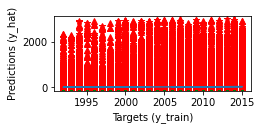

----------------------------------
Iteration:  5
Analyzing column: STATE_CODE
Coefficients:  [-0.54422946]
Mean squared error: 20815.80
Variance score: 0.00


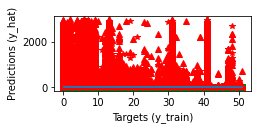

----------------------------------
Iteration:  6
Analyzing column: FIRE_SIZE_CLASS
Coefficients:  [35.29154254]
Mean squared error: 20516.40
Variance score: 0.04


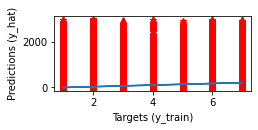

----------------------------------
Iteration:  6
Analyzing column: STAT_CAUSE_CODE
Coefficients:  [-4.86076766]
Mean squared error: 21185.20
Variance score: 0.01


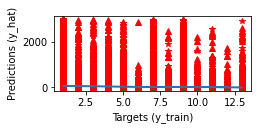

----------------------------------
Iteration:  6
Analyzing column: LONGITUDE
Coefficients:  [-1.19145077]
Mean squared error: 21078.08
Variance score: 0.02


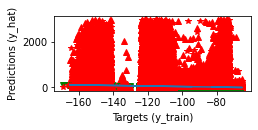

----------------------------------
Iteration:  6
Analyzing column: LATITUDE
Coefficients:  [3.72398025]
Mean squared error: 21006.16
Variance score: 0.02


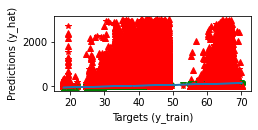

----------------------------------
Iteration:  6
Analyzing column: DISCOVERY_TIME
Coefficients:  [0.00058552]
Mean squared error: 21441.93
Variance score: -0.00


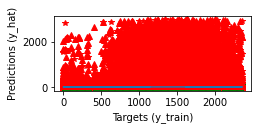

----------------------------------
Iteration:  6
Analyzing column: CONT_TIME
Coefficients:  [-0.01494762]
Mean squared error: 21398.50
Variance score: 0.00


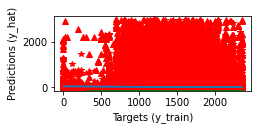

----------------------------------
Iteration:  6
Analyzing column: FIRE_YEAR
Coefficients:  [1.02794382]
Mean squared error: 21390.49
Variance score: 0.00


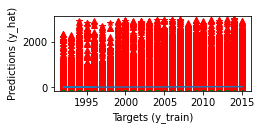

----------------------------------
Iteration:  6
Analyzing column: STATE_CODE
Coefficients:  [-0.52012291]
Mean squared error: 21389.65
Variance score: 0.00


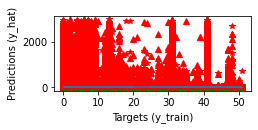

----------------------------------
Iteration:  7
Analyzing column: FIRE_SIZE_CLASS
Coefficients:  [35.07559562]
Mean squared error: 20688.33
Variance score: 0.05


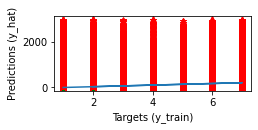

----------------------------------
Iteration:  7
Analyzing column: STAT_CAUSE_CODE
Coefficients:  [-4.84798534]
Mean squared error: 21411.84
Variance score: 0.01


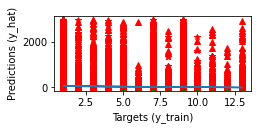

----------------------------------
Iteration:  7
Analyzing column: LONGITUDE
Coefficients:  [-1.19493062]
Mean squared error: 21320.06
Variance score: 0.02


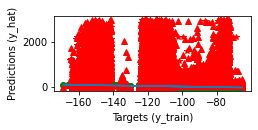

----------------------------------
Iteration:  7
Analyzing column: LATITUDE
Coefficients:  [3.71321108]
Mean squared error: 21228.84
Variance score: 0.02


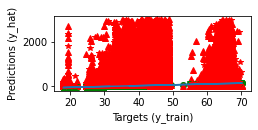

----------------------------------
Iteration:  7
Analyzing column: DISCOVERY_TIME
Coefficients:  [0.00027681]
Mean squared error: 21674.21
Variance score: 0.00


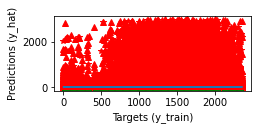

----------------------------------
Iteration:  7
Analyzing column: CONT_TIME
Coefficients:  [-0.01497298]
Mean squared error: 21631.43
Variance score: 0.00


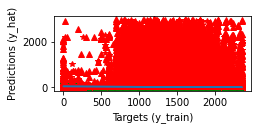

----------------------------------
Iteration:  7
Analyzing column: FIRE_YEAR
Coefficients:  [1.02362457]
Mean squared error: 21621.21
Variance score: 0.00


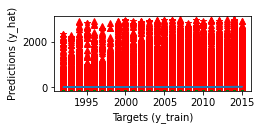

----------------------------------
Iteration:  7
Analyzing column: STATE_CODE
Coefficients:  [-0.53071288]
Mean squared error: 21630.64
Variance score: 0.00


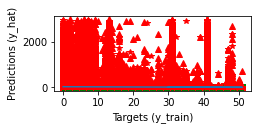

----------------------------------
Iteration:  8
Analyzing column: FIRE_SIZE_CLASS
Coefficients:  [34.68944026]
Mean squared error: 21770.05
Variance score: 0.05


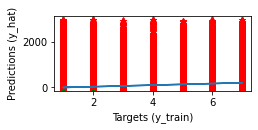

----------------------------------
Iteration:  8
Analyzing column: STAT_CAUSE_CODE
Coefficients:  [-4.81276177]
Mean squared error: 22569.69
Variance score: 0.01


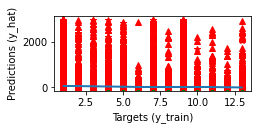

----------------------------------
Iteration:  8
Analyzing column: LONGITUDE
Coefficients:  [-1.1789978]
Mean squared error: 22453.16
Variance score: 0.02


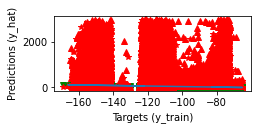

----------------------------------
Iteration:  8
Analyzing column: LATITUDE
Coefficients:  [3.67060074]
Mean squared error: 22362.27
Variance score: 0.02


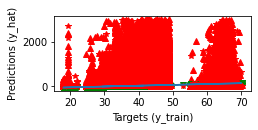

----------------------------------
Iteration:  8
Analyzing column: DISCOVERY_TIME
Coefficients:  [0.00044962]
Mean squared error: 22847.28
Variance score: -0.00


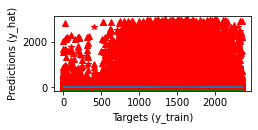

----------------------------------
Iteration:  8
Analyzing column: CONT_TIME
Coefficients:  [-0.01466374]
Mean squared error: 22797.68
Variance score: 0.00


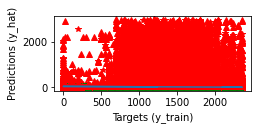

----------------------------------
Iteration:  8
Analyzing column: FIRE_YEAR
Coefficients:  [1.02508818]
Mean squared error: 22794.80
Variance score: 0.00


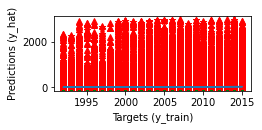

----------------------------------
Iteration:  8
Analyzing column: STATE_CODE
Coefficients:  [-0.5261841]
Mean squared error: 22800.00
Variance score: 0.00


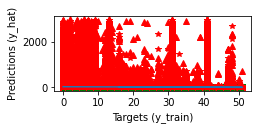

----------------------------------
Iteration:  9
Analyzing column: FIRE_SIZE_CLASS
Coefficients:  [35.01380374]
Mean squared error: 20896.12
Variance score: 0.05


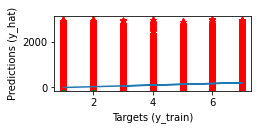

----------------------------------
Iteration:  9
Analyzing column: STAT_CAUSE_CODE
Coefficients:  [-4.85761098]
Mean squared error: 21646.21
Variance score: 0.01


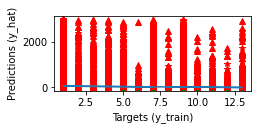

----------------------------------
Iteration:  9
Analyzing column: LONGITUDE
Coefficients:  [-1.19214655]
Mean squared error: 21543.22
Variance score: 0.02


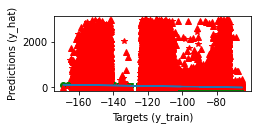

----------------------------------
Iteration:  9
Analyzing column: LATITUDE
Coefficients:  [3.71308963]
Mean squared error: 21457.92
Variance score: 0.02


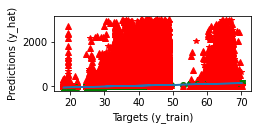

----------------------------------
Iteration:  9
Analyzing column: DISCOVERY_TIME
Coefficients:  [0.00064891]
Mean squared error: 21904.30
Variance score: -0.00


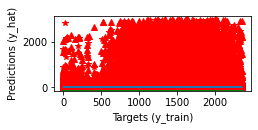

----------------------------------
Iteration:  9
Analyzing column: CONT_TIME
Coefficients:  [-0.01506242]
Mean squared error: 21863.06
Variance score: 0.00


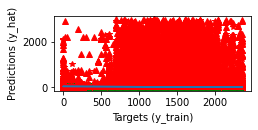

----------------------------------
Iteration:  9
Analyzing column: FIRE_YEAR
Coefficients:  [1.00782363]
Mean squared error: 21844.09
Variance score: 0.00


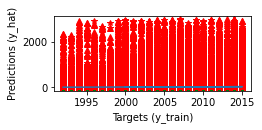

----------------------------------
Iteration:  9
Analyzing column: STATE_CODE
Coefficients:  [-0.52184126]
Mean squared error: 21853.29
Variance score: 0.00


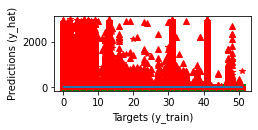

----------------------------------
Iteration:  10
Analyzing column: FIRE_SIZE_CLASS
Coefficients:  [34.90002599]
Mean squared error: 19735.26
Variance score: 0.05


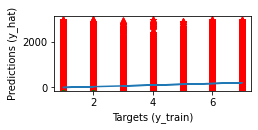

----------------------------------
Iteration:  10
Analyzing column: STAT_CAUSE_CODE
Coefficients:  [-4.82983529]
Mean squared error: 20491.10
Variance score: 0.01


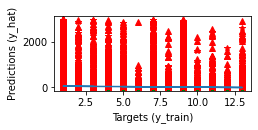

----------------------------------
Iteration:  10
Analyzing column: LONGITUDE
Coefficients:  [-1.18527572]
Mean squared error: 20382.01
Variance score: 0.02


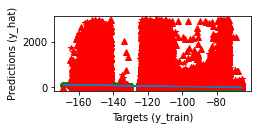

----------------------------------
Iteration:  10
Analyzing column: LATITUDE
Coefficients:  [3.7257726]
Mean squared error: 20326.50
Variance score: 0.02


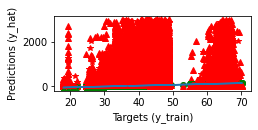

----------------------------------
Iteration:  10
Analyzing column: DISCOVERY_TIME
Coefficients:  [0.00064434]
Mean squared error: 20761.20
Variance score: -0.00


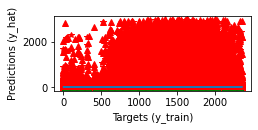

----------------------------------
Iteration:  10
Analyzing column: CONT_TIME
Coefficients:  [-0.01509687]
Mean squared error: 20721.19
Variance score: 0.00


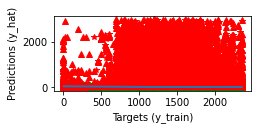

----------------------------------
Iteration:  10
Analyzing column: FIRE_YEAR
Coefficients:  [1.02877064]
Mean squared error: 20710.26
Variance score: 0.00


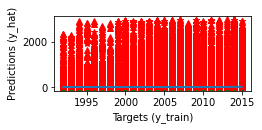

----------------------------------
Iteration:  10
Analyzing column: STATE_CODE
Coefficients:  [-0.5156855]
Mean squared error: 20705.25
Variance score: 0.00


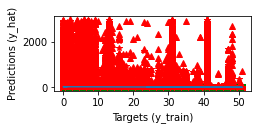

In [100]:
# this dictionary keeps track of the mse and the regression score for each column
# both values for each column are initially 0
# each iteration we'll keep a running total by adding the mse and regression score to the two values in the dictionary

d = {x: [0 , 0] for x in X_train.columns}

for j in range(10):
    # train and test split
    X_train, X_test, y_train, y_test = train_test_split(inputs, target, shuffle=True, test_size=0.2)
    for i, col in enumerate(X_train.columns):
        print("----------------------------------")
        print("Iteration: ", j + 1)
        print(f"Analyzing column: {col}")
        
        # create a linear regression object
        reg = LinearRegression()
        
        fig = plt.gcf();
        fig.set_size_inches(12, 8)
        plt.subplot(5, 3, i+1)

        # fit the regression with the scaled train inputs and targets
        reg.fit(X_train[[col]], y_train)
        # store the outputs of the regression in y_hat
        y_hat = reg.predict(X_train[[col]])
        y_pred = reg.predict(X_test[[col]])
        
        colors = {'y_train': 'red', 'y_hat': 'green'}
        # compare the target (y_train) and the prediction via plot
        plt.plot(X_train[col], y_hat, 'o', color='green') # predicted y for the training set
        plt.plot(X_train[col], y_train, '^', color='red') # actual y for the training set
        plt.plot(X_test[col], y_pred, 'v', color='green') # predicted y for the testing set
        plt.plot(X_test[col], y_test, '*', color='red') # actual y for the testing set

        # regression line
        m, b = np.polyfit(X_train[col], y_hat, 1)
    
        # axis labels
        plt.xlabel('Targets (y_train)', size=10)
        plt.ylabel('Predictions (y_hat)', size=10)
        
        # add the linear regression line to the plot
        plt.plot(X_train[col], m * X_train[col] + b)
    
        # show the coefficients
        print("Coefficients: ", reg.coef_)
        # show the mean squared error
        mse = np.mean((y_pred - y_test) ** 2)
        print("Mean squared error: %.2f" % mse)
        # show the explained variance score (1 is perfect)
        reg = reg.score(X_test[[col]], y_test)
        print("Variance score: %.2f" % reg)
        
        d[col][0] += mse
        d[col][1] += reg
        
        plt.show()

In [101]:
# add the score and mse to the dict
for key, val in d.items():
    val[0] = val[0]/10
    val[1] = val[1]/10
    
d['all'] = [sum(errors)/10, sum(scores)/10]
d['all']

[19775.159980741075, 0.10191788876294124]

Text(0, 0.5, 'MSE')

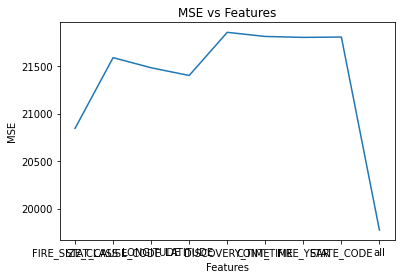

In [102]:
# plot it by taking the average over the 10 iterations
# use dict keys as the columns

plt.plot([x for x in d.keys()], [x[0] for x in d.values()])
plt.title('MSE vs Features')
plt.xlabel('Features')
plt.ylabel('MSE')

Text(0, 0.5, 'Variance Score')

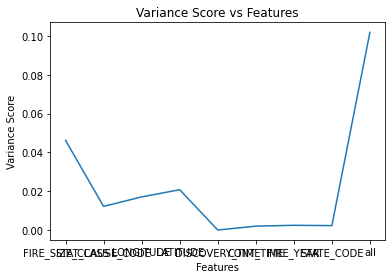

In [103]:
plt.plot([x for x in d.keys()], [x[1] for x in d.values()])
plt.title('Variance Score vs Features')
plt.xlabel('Features')
plt.ylabel('Variance Score')